### Sensitivity of the breakup to variations in ice thickness and wind speed

#### Author: Jonathan Rheinlænder*
#### Date: Aug. 30 2021
#### Affiliation: Nansen Environmental and Remote Sensing Center, Bergen, Norway
*jonathan.rheinlaender@nersc.no


In [6]:
# allow plots to be interactive in the notebook
%matplotlib notebook
import cartopy
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import struct
import xarray as xr
from datetime import datetime
import matplotlib as mpl
import sys
import os
import cmocean 
import datetime as dt
from netCDF4 import Dataset
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.inset_locator import inset_axes

import pynextsim.openers as pnops
import mod_netcdf_utils as mnu
import pynextsim.gridding as png
from pynextsim.netcdf_list import NetcdfList
from pynextsim.irregular_grid_interpolator import IrregularGridInterpolator
import matplotlib.pyplot as plt
from pynextsim.nextsim_bin import NextsimBin as nb
from pynextsim.projection_info import ProjectionInfo
from shutil import copyfile
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.axes_grid1.colorbar import colorbar

In [3]:
def mask_region(sio_mask, proj, mooring, n):
    """
    This function will compute mask
    :param sio_mask: masks from NSIDC (xarray)    
    :param proj: the projection used by NSIDC (projection_info object)
    :param mooring: moorings from nextsim (xarray)
    :param n: integer to pick which region to mask
    :return: boolean mask
    """
    # get variables from sio mask
    masks_nsidc = sio_mask["mask"][:]
    lon_nsidc = sio_mask.lon
    lat_nsidc = sio_mask.lat
    region_names = sio_mask['region_names']

    print("NSIDC grid extent:    ", lon_nsidc.values.min(), lon_nsidc.values.max(), 
          lat_nsidc.values.min(), lat_nsidc.values.max())

    # calculate x and y projection
    x_nsidc,y_nsidc= proj(lon_nsidc.values,lat_nsidc.values)
    
    #### I want an array with 0s everywhere but within the region I am interested
    mask_nsidc = np.zeros(masks_nsidc.shape)
    mask_nsidc[masks_nsidc==n] = 1
    print("Region: ", region_names[n-1].values)    # print region
    
    ### get lon, lat from nextsim
    nlon = mooring.longitude.values
    nlat = mooring.latitude.values
    
    # I project the model lon, lat on the nsidc projection and get 1d vector out of them
    x,y = proj(nlon, nlat)
    x = np.array(x) ; y=np.array(y)
    Nx     = x.size
    shp    = x.shape
    x_1d   = x.reshape(Nx)
    y_1d   = y.reshape(Nx)

    ##### This below cannot be removed, it is a trick: I use matplotlib to find the contour of my region
    all_paths = plt.contour(x_nsidc,y_nsidc,mask_nsidc,[0.5]).collections[0].get_paths()
    ##### I look for the biggest contour : WARNING, I might forget some little bits by doing that, I haven't checked too carefully
    max_len=0
    for i in range(len(all_paths)):
        if len(all_paths[i])>max_len:
            max_len=len(all_paths[i])
            bbPath=all_paths[i]
        
    ###### I select all the indexes that are within the (biggest) contour of my region
    coords = np.array([x_1d,y_1d]).transpose()
    mask_1d = np.array(bbPath.contains_points(coords),dtype=bool)

    ###### Back to 2d
    mask   = mask_1d.reshape(shp)
    print(mask, mask.shape)
    ##### A boolean array can also be useful
    mask_box = (mask==True)

    return mask

def make_figure(wi, hi, nrow,ncol):

    fig = plt.figure(figsize=(wi,hi))
    #plt.subplots_adjust(hspace=5, wspace=0.01, top=0.95, bottom=0.1, left=0.075, right=0.925)
    gs = gridspec.GridSpec(nrow,ncol)
    
    return fig, gs 


def plot(xa, gs, clim):
    ax = plt.subplot(gs,projection=ccrs.NorthPolarStereo(central_longitude=300), extent=[-110, 200, 67, 90])
    #make discrete colormap
    levels = np.arange(clim[0], clim[1], clim[2])
    bounds=np.linspace(0,4,9)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

    ax.coastlines(resolution='50m', linewidth=0.5)
    ax.gridlines(linewidth=0.5, alpha=0.5, linestyle='--')
    ax.set_extent(bbox, crs=ccrs.NorthPolarStereo())

    cs = ax.contourf(xa, origin='upper', extent=bbox, levels=levels,
                    extend='max', transform=ccrs.NorthPolarStereo())
    
    # add contour line
    cline = ax.contour(xa, origin='upper', extent=bbox, levels=[2], 
                       colors='k', linewidths=1, transform=ccrs.NorthPolarStereo())
    
    
#    fig.colorbar(cs, label='Thickness [m]', fraction=0.04, pad=0.02)
    ax.set_extent([-110, -50, 67, 90], ccrs.PlateCarree(central_longitude=300))
    
    return cs,ax


In [7]:
rootdir = '/cluster/projects/nn9624k/rheinlender/breakup2013/data/wrf-exp/start_20130213_nudging/'
expts = ["expt_01_wrf10/outputs-v11/", "expt_05_wrf10-sitx0.5/outputs/","expt_06_wrf10-sitx1.5/outputs/", 
         "expt_07_wrf10-sitx2.0/outputs/", "expt_01_wrf10-nodyn/outputs/"]

files = [os.path.join(rootdir, f, 'Moorings.nc') for f in expts]

ds0 = xr.open_dataset(files[0])
ds1 = xr.open_dataset(files[1])
ds2 = xr.open_dataset(files[2])
ds3 = xr.open_dataset(files[3])
ds4 = xr.open_dataset(files[4])

dslist = [ds0, ds1, ds2, ds3]

time = ds0['time'].time.values.astype('datetime64[ms]').astype('O')

# subset region: Beaufort Sea
x0=0; x1=260
y0=150; y1=410


# plot histogram of the leadfraction in the Beaufort Sea on March 1 2013

Text(0.5, 1.0, 'Leadfraction - 2013-03-01')

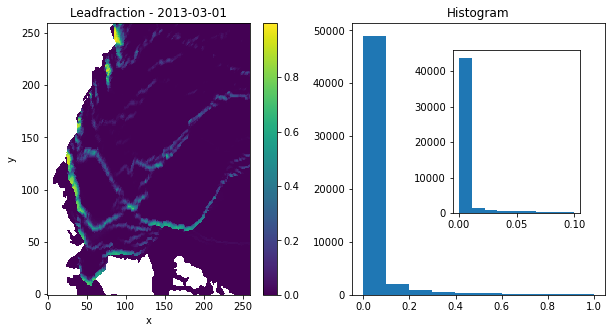

In [62]:
bins = np.linspace(0,0.1,10)   
dto = "2013-03-01"

sel = leadfraction.sel(x=slice(x0,x1), y=slice(y0,y1), time=dto)
sel = sel.mean(axis=0) # daily average

fig, axes = plt.subplots(figsize=(10,5),ncols=2)
sel.plot.imshow(ax=axes[0])
sel.plot.hist(ax=axes[1])

# add inset axis (zoom in)
axin1 = axes[1].inset_axes([0.4, 0.3, 0.5, 0.6])
sel.plot.hist(ax=axin1, bins=bins)
axin1.set_title('')

axes[0].set_title("Leadfraction - 2013-03-01")


Despite all the fractures, most of the sea ice is still considered pack ice. Therefore, to only consider actual leads we use a cutoff value off 0.05. 

# Plot initial thickness distributions for sensitivity expts

In [ ]:

dto = dt.datetime(2013,2,13,12,0) # date to plot

rootdir = '/cluster/home/rheinlender/data/CS2_SMOS_v2.2/'
fl = ['cs2_smos_ice_thickness_' + dto.strftime("%Y%m%d") + '-fv2p2.nc', 
      'cs2_smos_ice_thickness_' + dto.strftime("%Y%m%d") + '-fv2p2_times0.5.nc', 
     'cs2_smos_ice_thickness_' + dto.strftime("%Y%m%d") + '-fv2p2_times1.5.nc',
     'cs2_smos_ice_thickness_' + dto.strftime("%Y%m%d") + '-fv2p2_times2.0.nc',] 

# get cs2smos opener
o = pnops.OpenerCs2SmosThick()
o.variables['Thickness'].name = 'analysis_sea_ice_thickness'    

# read mooring file (for plotting)
moorings = NetcdfList([
    '/cluster/projects/nn9624k/rheinlender/breakup2013/data/wrf-exp/start_20130213_nudging/expt_01_wrf10/outputs-v11/Moorings.nc'])

# get bounding box from model (i.e. small_arctic_10km)
bbox = moorings.file_objects[0].get_bbox(o.projection.pyproj)
text = ('a', 'b', 'c', 'd')

# make figure
fig,gs = make_figure(6,2,1,4) 

i=0
for filename in fl:
    filename = rootdir + filename
    print("Opening:", filename)
    
    nci_obs = mnu.nc_getinfo(filename)
    obs_grid = png.Grid.init_from_nc_getinfo(nci_obs, projection=o.projection, bbox=bbox)    #cs2smos grid
    obs_vars = obs_grid.get_external_data(
                o.variables,
                dto,
                nci=nci_obs,
                data_on_same_grid=True, #we always use the obs grid
                allow_missing=True)

    sit = obs_vars['Thickness']

    # plotting
    cs,ax=plot(sit, gs[i], clim=[0.,4.5,0.5])
    
    ax.annotate(text[i], xy=(0., 1.05), xycoords="axes fraction", size=12, weight='bold')
        
    
    i+=1 

cax = inset_axes(fig.axes[3],
                    width="5%",  # width = 50% of parent_bbox width
                    height="100%",  # height : 5%
                    loc='lower left',
                    bbox_to_anchor=(1.05, 0., 1, 1),
                    bbox_transform=fig.axes[3].transAxes,
                    borderpad=0)

plt.colorbar(cs, cax=cax, label='Thickness (m)',  ticks=[0, 1, 2, 3, 4])
    
plt.subplots_adjust(wspace=0.03, hspace=0, top=0.95, bottom=0.1, left=0.02, right=0.9)
plt.show()   

title_string = ('wrf10', r'SIT$\times$0.5', r'SIT$\times$1.5', r'SIT$\times$2.0')
for i in range(0,len(fl)):
    ax=fig.axes[i]
    ax.set_title(title_string[i])

# save figure
outpath_plots = '/cluster/home/rheinlender/projects/aoi_case_study/python/breakup-paper/figs/'
figname = os.path.join(outpath_plots,
      '%s%s_%s_%s' % (outpath_plots, 'cs2smos_sit_beaufort', dto.strftime('%Y%m%d'), 'initial_fields.png'))
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')

# Plot timeseries of ice velocity, wind speed and lead fraction in the Beaufort Sea

In [ ]:
def calc_leadfraction(ds):
    
    owfraction = 1 - ds['sic']
    leadfraction = owfraction + ds['sic_thin']
    #leadfraction = leadfraction.where(mooring['sit']<10)

    c = 0.05
    leadmap = xr.where(leadfraction>c, 1, 0)
    nlead = np.count_nonzero(leadmap)
    # apply land_mask
   # leadmap = leadmap.where(~land_mask)
    
    return leadmap, nlead

In [ ]:
cell_area = 25*1e6 # m2
ocn_mask = ~xr.ufuncs.isnan(ds0['sic'])[0]# create ocean mask
weights = ~xr.ufuncs.isnan(ds0['sic'])*cell_area # m2
BSarea = weights.sel(x=slice(x0,x1), y=slice(y0,y1)).sum(dim=("x", "y")).values

labelstr = ["wrf10", "SIT*0.5", "SIT*1.5", "SIT*2.0"]
fig, ax = plt.subplots(2,1, figsize=(6,5))
for i, ds in enumerate(dslist):
 
    leadmap, nlead = calc_leadfraction(ds) # binary - leadmap=1: lead, leadmap=0: packice    

    # calculate average heat fluxes in Beaufort Sea
    #hfs_leads = ds['hfs'].where(leadmap) # in leads only
    hfs_w = ds['hfs'] * weights
    hfs_w = hfs_w.sel(x=slice(x0,x1), y=slice(y0,y1)) 
    hfs_wsum = hfs_w.sum(dim=("x", "y"))
    hfsBS_mean = hfs_wsum/BSarea # divide by total area
    
    # apply NSIDC mask
  # leadmap = leadmap.where(mask==1)

    # apply large mask 
    leadmap = leadmap.sel(x=slice(x0,x1), y=slice(y0,y1))   
    
    # Calculate the mean lead area fraction as a fraction of the Beaufort Sea area
    lead_area_fraction = leadmap.mean(dim=("x", "y"))*100 # in %

    # calculate ice velocity 
    ds['icevel'] = (ds['siu']**2 + ds['siv']**2)**0.5
    icevel = ds['icevel'].sel(x=slice(x0,x1), y=slice(y0,y1)).mean(dim=('x','y'))*1e2 # cm/s
    
    
    # calculate mean ice thickness
    sit_mean = ds['sit'].sel(x=slice(x0,x1), y=slice(y0,y1)).mean(dim=('x','y')) # m
    sit_anom = sit_mean - sit_mean.mean(dim='time')
    
    ## Plotting
    l0 = ax[0].plot(time, icevel, label=labelstr[i])
    l1 = ax[1].plot(time, lead_area_fraction, label=labelstr[i])
    #l2 = ax[2].plot(time, sit_anom, label=labelstr[i])

# Add y-axes to top plot: maximum ywind along transect
ax2 = ax[0].twinx()
l2 = ax2.plot(time, ds0['wndy'].sel(x=100, y=slice(180, 450)).max(dim=('y')), 
              color='black', 
              linewidth='1', 
             # alpha=0.9,
              linestyle=':')

ax2.set_ylabel("Max wind (m s$^{-1}$)")
ax[0].set_ylabel("Ice velocity (cm s$^{-1}$)")
ax[1].set_ylabel("Lead Fraction (%)")
#ax[2].set_ylabel("Heat Flux [W/m$^2$]")

for axes in ax.flat:
    axes.grid(linestyle='--', alpha=0.4)
    days = mdates.DayLocator()  # every day
    dtFmt = mdates.DateFormatter('%b %d') # define the formatting 
    axes.xaxis.set_major_formatter(dtFmt)
    axes.xaxis.set_minor_locator(days)
    
# label stuff
ax[0].set_ylim([-2,18])
ax[1].legend(loc='upper left')# add legend 
ax[1].yaxis.set_ticks(np.arange(0, 12+4, 4))
#ax[0].set_xticklabels([''])

fig.subplots_adjust(bottom=0.1, top=0.96, left=0.12, right=0.9, wspace=0.1, hspace=0.3)
plt.show()

# save figure
outpath_plots = '/cluster/home/rheinlender/projects/aoi_case_study/python/breakup-paper/figs/'
figname = os.path.join(outpath_plots,
      '%s%s' % (outpath_plots, 'icevel_leadfrac_beaufort-std_0.5_1.5_2.0.png'))
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')

# Plot maps of integrated damage for the sensitivity expts

In [ ]:
def prepare_grid():
    extent = [-110, 200, 67, 90]
    proj = ProjectionInfo() # default nextsim projection

    # Get x-y grid from model
    lons = ds.longitude[:]
    lats = ds.latitude[:]
    x,y=proj.pyproj(lons.values, lats.values) # init grid using x,y coords of grid
    x_extent = [(x,y)[0][0][0], (x,y)[0][0][-1]]
    y_extent = [(x,y)[1][0][0], (x,y)[1][-1][0]]
    ex_lim=1
    x_extent = [(x,y)[0][0][ex_lim], (x,y)[0][0][-ex_lim]]
    y_extent = [(x,y)[1][ex_lim][0], (x,y)[1][-ex_lim][0]]

    grid = dict(
        extent=extent, 
        proj=proj,
        x_extent=x_extent,
        y_extent=y_extent,)
    return grid

t1 = '2013-02-19'
t2 = '2013-03-13'

cmap=cmocean.cm.thermal
clim=[0.5, 0.95]
clevs = np.arange(clim[0], clim[1], (clim[1]-clim[0])/100)
grid = prepare_grid()

# make figure
fig,gs = make_figure(6,2,1,4) 
for i, ds in enumerate(dslist):
    ax = plt.subplot(gs[i],projection=ccrs.NorthPolarStereo(central_longitude=300), extent=[-110, 200, 67, 90])
    
    dam_ave = ds['damage'].sel(time=slice(t1,t2)).mean(dim='time')
    
    # prepare axes
    ax = plt.subplot(gs[i], projection=grid['proj'].crs, extent=grid['extent'])

    cs = ax.contourf(dam_ave, zorder=1, extent=[*grid['x_extent'], *grid['y_extent']],
                     cmap=cmap, levels=clevs,  extend='both')

    ax.add_feature(cartopy.feature.LAND,zorder=1,alpha=1)
    ax.coastlines(resolution='50m', linewidth=0.5)
    ax.set_aspect(1)
    ax.gridlines(zorder=2,linewidth=0.5, alpha=0.5,linestyle="--")

cax = inset_axes(fig.axes[3],
                    width="5%",  # width = 50% of parent_bbox width
                    height="100%",  # height : 5%
                    loc='lower left',
                    bbox_to_anchor=(1.05, 0., 1, 1),
                    bbox_transform=fig.axes[3].transAxes,
                    borderpad=0)

plt.colorbar(cs, cax=cax, label='Damage', ticks=[0.5, 0.6, 0.7, 0.8, 0.9])
    
plt.subplots_adjust(wspace=0.03, hspace=0, top=0.95, bottom=0.1, left=0.02, right=0.88)
plt.show()   

title_string =("wrf10", "SIT*0.5", "SIT*1.5", "SIT*2.0")
for i in range(0,len(fl)):
    ax=fig.axes[i]
    ax.set_title(title_string[i])

# save figure
outpath_plots = '/cluster/home/rheinlender/projects/aoi_case_study/python/breakup-paper/figs/'
figname = os.path.join(outpath_plots,
      '%s%s_%s-%s_%s' % (outpath_plots, 'damage_beaufort', t1, t2, 'sensitivity_expts.png'))
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')

# Leadfraction without using a cut-off value

/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray (y: 260, x: 260)>
array([[          nan,           nan,           nan, ..., 1.3583068e-05,
        1.3583068e-05, 1.4149626e-05],
       [          nan,           nan,           nan, ..., 1.4007439e-05,
        1.3583068e-05, 1.4149626e-05],
       [          nan,           nan,           nan, ..., 1.4083446e-05,
        1.4328225e-05, 1.4269797e-05],
       ...,
       [          nan,           nan,           nan, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [          nan,           nan,           nan, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [          nan,           nan,           nan, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)
Dimensions without coordinates: y, x

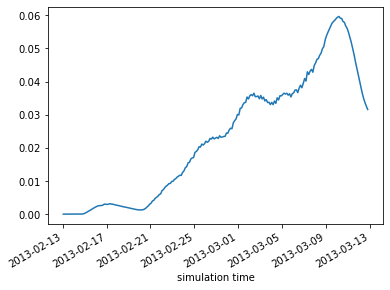

In [38]:
%matplotlib inline
owfraction = 1 - ds0['sic']
leadfraction = owfraction + ds0['sic_thin']

cell_area = 25*1e6 # m2

leadfraction_area = leadfraction*cell_area # get the lead fraction in terms of area (m2)
leadfraction_areaBS = leadfraction_area.sel(x=slice(x0,x1), y=slice(y0,y1))

# get beaufort Sea area
ocn_mask = ~xr.ufuncs.isnan(ds0['sic'])[0]# create ocean mask
weights = ~xr.ufuncs.isnan(ds0['sic'])*cell_area # m2
BSarea = weights.sel(x=slice(x0,x1), y=slice(y0,y1)).sum(dim=("x", "y")).values 

leadfraction_areaBS_sum = leadfraction_areaBS.sum(dim=('x', 'y'))/BSarea

plt.figure()
leadfraction_areaBS_sum.plot()
